### Описание:
Классифицировать игроков в каждом кадре по двум командам на основе цвета их формы.

### Данные:
Скачайте архив с данными [отсюда](https://disk.yandex.ru/d/NMlVHytktlzbEw) и распакуйте. Внутри архива лежит папка `frames` и файл `bboxes.json`. Файл `bboxes.json` содержит bounding boxes игроков двух команд, а в папке `frames` расположены соответствующие им изображения (кадры). Всего дано 100 кадров. Каждому кадру соответствует 10 bounding boxes игроков.

Структура файла `bboxes.json` следующая:
```
frame_n: {
     player_1: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
     plyaer_10: { .... }
}
....
frame_n+k: { .... }
```
Здесь `frame_n` - номер кадра (ему соответствует файл с изображением в папке frames, всего 100),<br>
`player_1` - id игрока в текущем кадре,<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).
Такм образом, id игроков и id команд имеют смысл только в пределах одного кадра и не связаны с другими кадрами. Т.е. в разных кадрах одному и тому же игроку / команде может соответствовать разные id.

### Задачи:
1) Классифицируйте игроков, используя в качестве вектора признаков игрока (features) средний цвет в пространстве RGB, который берется из области изображения, покрытой bounding box этого игрока (т.е. вектор признаков будет состоять из 3 элементов `[r,g,b]`.<br>
2) Используйте в качестве вектора признаков игроков их средний цвет в пространстве HSV (аналогично вектор признаков `[h,s,v]`.<br>
3) Используйте в качестве вектора признаков гистограмму в пространстве RGB, а не средний цвет. Число бинов определите самостоятельно.<br>
4) Используйте в качестве вектора признаков гистограмму в пространстве HSV.

### Как классифицировать:
В качестве классификатора можете использовать:
- Методы без обучения: k-means (на 2 кластера) или другие методы кластеризации.
- Методы с обучением: K-Nearest Neighbors, RandomForest, GaussianNB или др.

### Результаты:
1. Посчитайте точность классификации для каждого варианта и сравните результаты. 
2. Задание будет принято, если итоговая точность будет выше чем 0.5
3. [опционально] При тестировании на закрытой выборке в конце курса будет подведен итог (рекорд по всем курсам на данный момент - ***0.903***).

#### Полезные советы
- Боксы игроков имеют разный размер, поэтому нормализуйте гистограмму перед ее использованием в качестве вектора признаков (делите значения гистограммы на площадь бокса). 
- Большое число бинов гистограммы может привести к худшим результатам, поэтому попробуйте использовать 8/16/32.
- Для построения вектора признаков лучше использовать некоторую его центральную область, т.к. она покрывает игрока, а границы часто содержут фон / других игроков.

## Тестирование на закрытой выборке (опционально)

Скачайте архив с тестовыми данными [отсюда](https://disk.yandex.ru/d/oSRWELxpClOasg). Внутри архива 100 изображений в папке `frames` (из той же игры), и файл `bboxes_test.json`, который содержит только `bounding boxes` игроков (и не содержит полей `'team'`). 

Используйте вашу лучшую модель классификатора на эти данных. В качестве результата загрузите в ЛК файл `test_results.json` который должен содержать следующие данные (пример файла можно посмотреть [здесь](https://disk.yandex.ru/d/ODjibULNGtVnNw)):
```
frame_n: {
     player_1: team_id,
     .....
     plyaer_10: team_id
},
....
frame_n+k: { .... }
``` 
где `team_id` - метка команды (0 или 1).

После этого преподаватель сообщит вам accuracy вашей модели на тестовых данных.

## Как посчитать accuracy

In [14]:
def compare(vec, gt):
    res = [1 if g in vec else 0 for g in gt]
    return res

# GT:
gt_team1 = [0, 1, 2, 3, 5, 6, 7, 8]
gt_team2 = [4, 9]

# Predictions:
team1 = [0, 2, 3, 5, 6]
team2 = [1, 4, 7, 8, 9]

# Calculate accuracy:
res1 = compare(team1, gt_team1)
res2 = compare(team2, gt_team2)
accuracy = sum(res1+res2) / len(gt_team1+gt_team2)
if accuracy < 0.5:
    res1 = compare(team1, gt_team2)
    res2 = compare(team2, gt_team1)
    accuracy = sum(res1+res2) / len(gt_team1+gt_team2)

print(res1, res2, 'accuracy:', accuracy)

[1, 0, 1, 1, 1, 1, 0, 0] [1, 1] accuracy: 0.7


https://colab.research.google.com/drive/1oIlav-TGp4qLfP1tFrwy0F0yJ5BBEfY9?usp=sharing

## Решение

In [79]:
from PIL import Image
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, cv, Pool
import pandas as pd
import numpy as np
import json

In [2]:
df_features = pd.read_parquet("../data/df_features_train.pa")

In [3]:
df_features.tail()

,img_id,player_id,team,r_mean,g_mean,b_mean,h_mean,s_mean,v_mean,mean_4_0,...,mean_32_0,mean_32_1,mean_32_2,mean_32_3,mean_32_4,mean_32_5,mean_32_6,mean_64_0,mean_64_1,mean_64_2
5,170704,5,0,170.901294,146.156553,115.134142,67.950728,95.732605,172.546117,0.000748,...,0.002020,0.004288,0.002468,0.001388,0.001214,0.001717,0.004230,0.003154,0.001928,0.001465
6,170704,6,0,171.287653,142.881421,109.529354,65.819977,113.167967,176.005999,0.000000,...,0.000450,0.003409,0.004303,0.002144,0.001542,0.001878,0.006825,0.001929,0.003223,0.001710
7,170704,7,1,156.446883,127.410736,108.621872,78.184014,113.285788,166.674477,0.000192,...,0.001088,0.004807,0.003663,0.003009,0.002214,0.002213,0.004611,0.002947,0.003336,0.002213
8,170704,8,1,150.716566,129.355191,107.338510,74.957866,92.151711,151.762439,0.000863,...,0.002809,0.005568,0.002957,0.002072,0.001739,0.002036,0.002831,0.004188,0.002514,0.001887
9,170704,9,1,135.395487,118.060735,123.800516,110.148549,81.900709,142.498388,0.000129,...,0.003204,0.004251,0.003881,0.003772,0.003655,0.003788,0.002740,0.003727,0.003826,0.003721


In [4]:
df_features.shape

(1000, 97)

In [5]:
df_features.team.mean()

0.498

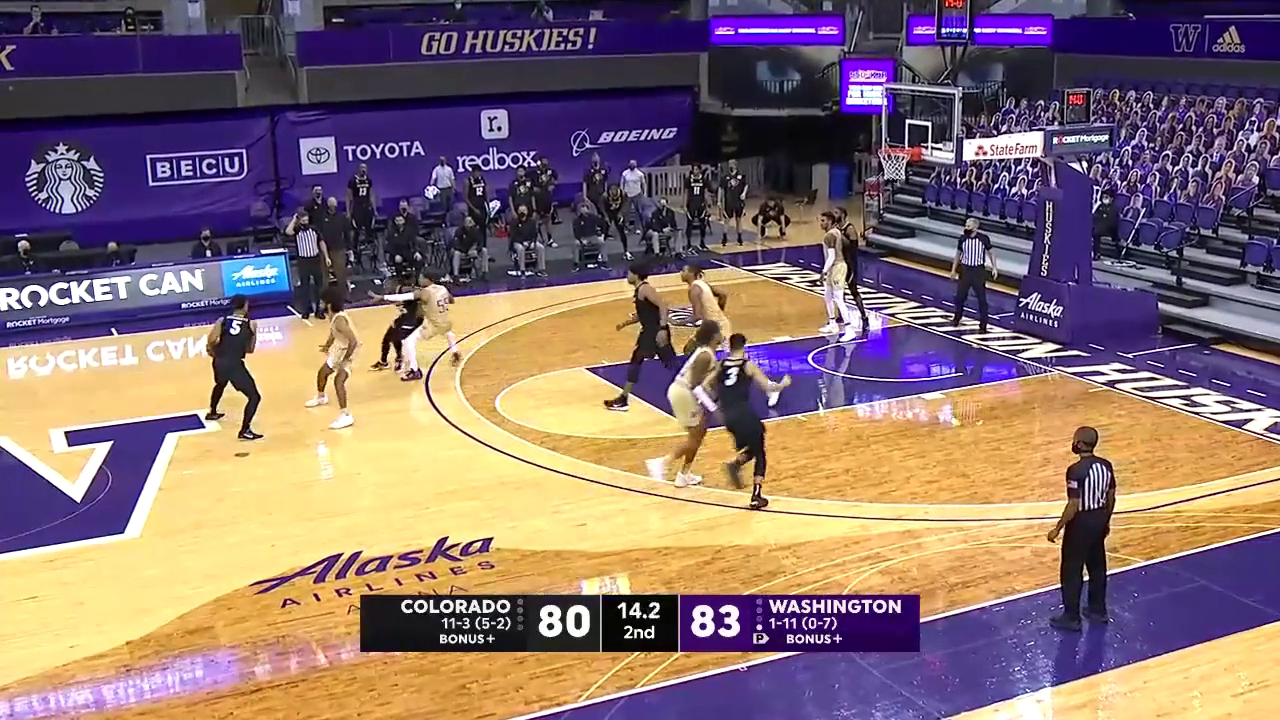

In [6]:
img = Image.open("../data/frames/170704.jpeg")
img

In [8]:
# Загрузка данных
df = df_features
features = list(df_features.loc[:, 'team':].columns[1:].values)
target = 'team'

# Создание Pool
data_pool = Pool(data=df[features], label=df[target])

# Начальные параметры CatBoost
params = {
    'loss_function': 'Logloss',  # Замените на вашу функцию потерь, если необходимо
    'learning_rate': 0.03,
    'eval_metric': 'AUC',  # Метрика для оценки качества
    'random_seed': 42,
    'verbose': False,
    'early_stopping_rounds': 50  # Остановить после 50 итераций без улучшения
}

# Список количеств деревьев для проверки
iterations_list = [100, 300, 500, 700, 1000]

best_auc = 0
best_iterations = 0

# Перебор разного количества деревьев
for iterations in iterations_list:
    print(f"Тестируем количество деревьев: {iterations}")
    params['iterations'] = iterations
    
    cv_results = cv(
        params=params,
        pool=data_pool,
        fold_count=5,
        shuffle=True,
        partition_random_seed=0,
        plot=False,
        stratified=True,
        verbose=False
    )
    
    max_auc = np.max(cv_results["test-AUC-mean"])
    print(f"Средний AUC с {iterations} итерациями: {max_auc}")
    
    if max_auc > best_auc:
        best_auc = max_auc
        best_iterations = iterations

print(f"\nЛучшее количество деревьев: {best_iterations} с AUC = {best_auc}")

# Обновление параметров с лучшим количеством деревьев
params['iterations'] = best_iterations

Тестируем количество деревьев: 100
Training on fold [0/5]

bestTest = 0.8997029703
bestIteration = 86

Training on fold [1/5]

bestTest = 0.9077227723
bestIteration = 94

Training on fold [2/5]

bestTest = 0.9268
bestIteration = 94

Training on fold [3/5]

bestTest = 0.9054545455
bestIteration = 92

Training on fold [4/5]

bestTest = 0.896969697
bestIteration = 57

Средний AUC с 100 итерациями: 0.9065691289128914
Тестируем количество деревьев: 300
Training on fold [0/5]

bestTest = 0.9011881188
bestIteration = 138

Training on fold [1/5]

bestTest = 0.9108910891
bestIteration = 159

Training on fold [2/5]

bestTest = 0.9293
bestIteration = 166

Training on fold [3/5]

bestTest = 0.9154545455
bestIteration = 281

Training on fold [4/5]

bestTest = 0.896969697
bestIteration = 57

Средний AUC с 300 итерациями: 0.9104420682068207
Тестируем количество деревьев: 500
Training on fold [0/5]

bestTest = 0.9011881188
bestIteration = 138

Training on fold [1/5]

bestTest = 0.9108910891
bestIterat

In [18]:
# Инициализация KFold
kf = KFold(n_splits=5, shuffle=False)

# Список для хранения предсказаний на новом датасете
df["prediction"] = 0

# Обучение модели и создание предсказаний для нового датасета
for train_index, test_index in kf.split(df[features]):
    # Разделение данных на обучающий и тестовый наборы
    X_train, X_test = df[features].iloc[train_index], df[features].iloc[test_index]
    y_train, y_test = df[target].iloc[train_index], df[target].iloc[test_index]

    # Обучение модели CatBoost
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    
    # Предсказание на новом датасете и сохранение результатов
    predictions = model.predict_proba(X_test)[:, 1]  # Предполагаем, что интересует вероятность класса 1
    df.iloc[test_index, -1] += predictions / kf.n_splits  # Усреднение предсказаний

In [20]:
df["prediction"].describe()

count    1000.000000
mean        0.099300
std         0.065054
min         0.001524
25%         0.032440
50%         0.107681
75%         0.161486
max         0.198596
Name: prediction, dtype: float64

In [22]:
roc_auc_score(df["team"], df["prediction"])

0.8934542952687243

In [23]:
df["team_pred"] = 0
df.loc[df.prediction > df.prediction.median(), "team_pred"] = 1

In [27]:
df.groupby(["team", "team_pred"]).size().unstack()

team_pred,0,1
team,,
0,419,83
1,81,417


In [28]:
(419 + 417) / 1000

0.836

In [29]:
df_test_features = pd.read_parquet("../data/df_features_test.pa")

In [30]:
df_test_features.head()

,img_id,player_id,r_mean,g_mean,b_mean,h_mean,s_mean,v_mean,mean_4_0,mean_4_1,...,mean_32_0,mean_32_1,mean_32_2,mean_32_3,mean_32_4,mean_32_5,mean_32_6,mean_64_0,mean_64_1,mean_64_2
0,1407,0,177.408914,150.271110,113.598470,62.464895,102.400255,181.141361,0.006477,0.000084,...,0.001424,0.004292,0.000923,0.000845,0.002026,0.002022,0.006085,0.002858,0.000884,0.002024
1,1407,1,109.570386,95.988805,111.997650,129.875804,96.396215,125.863496,0.000897,0.001067,...,0.002517,0.008530,0.005338,0.004156,0.003019,0.002445,0.002176,0.005523,0.004747,0.002732
2,1407,2,97.148386,82.195476,85.677947,103.616742,120.532049,118.439604,0.001200,0.000940,...,0.005136,0.008913,0.004433,0.001788,0.002319,0.004727,0.003281,0.007024,0.003110,0.003523
3,1407,3,199.575111,166.185284,116.531786,45.412082,114.623868,200.467193,0.000008,0.000008,...,0.000668,0.001746,0.001095,0.000837,0.001187,0.003282,0.007611,0.001207,0.000966,0.002235
4,1407,4,109.883308,95.377180,100.705940,112.756654,118.262481,133.998872,0.002039,0.001532,...,0.005774,0.006248,0.004656,0.002081,0.001781,0.004321,0.004011,0.006011,0.003368,0.003051


In [31]:
df_test_features.shape

(1000, 96)

In [32]:
# Обучение финальной модели на всем исходном датасете
final_model = CatBoostClassifier(**params)
final_model.fit(data_pool)

new_df = df_test_features
new_data_pool = Pool(data=new_df[features])  # Предполагаем, что в новом датасете те же самые признаки, что и в исходном
predictions = final_model.predict_proba(new_data_pool)[:, 1]  # Предсказываем вероятности для класса "1"

In [34]:
len(predictions)

1000

In [37]:
df_test_features['prediction'] = predictions

In [38]:
df_test_features["team_pred"] = 0
df_test_features.loc[df_test_features.prediction > df_test_features.prediction.median(), "team_pred"] = 1

In [41]:
df_test_cut = df_test_features[["img_id", "player_id", "team_pred"]]

In [43]:
df_test_cut.rename(columns={"img_id": "frame_n"}, inplace=True)

C:\Users\prampampam\AppData\Local\Temp\ipykernel_22116\3778391869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cut.rename(columns={"img_id": "frame_n"}, inplace=True)


In [46]:
df_test_cut.groupby("frame_n").team_pred.mean().describe()

count    100.000000
mean       0.500000
std        0.107309
min        0.200000
25%        0.400000
50%        0.500000
75%        0.600000
max        0.800000
Name: team_pred, dtype: float64

In [49]:
df_test_cut["frame_n"] = df_test_cut["frame_n"].astype(str)
df_test_cut["player_id"] = df_test_cut["player_id"].astype(str)

C:\Users\prampampam\AppData\Local\Temp\ipykernel_22116\2272031448.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cut["frame_n"] = df_test_cut["frame_n"].astype(str)
C:\Users\prampampam\AppData\Local\Temp\ipykernel_22116\2272031448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cut["player_id"] = df_test_cut["player_id"].astype(str)


In [50]:
df_test_cut.dtypes

frame_n      object
player_id    object
team_pred     int64
dtype: object

In [51]:
df_test_cut.rename(columns={"team_pred": "team"}, inplace=True)

C:\Users\prampampam\AppData\Local\Temp\ipykernel_22116\3839619179.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cut.rename(columns={"team_pred": "team"}, inplace=True)


In [67]:
df_test_cut['simple_dict'] = df_test_cut.apply(lambda r: {"team": r["team"]}, axis=1)

C:\Users\prampampam\AppData\Local\Temp\ipykernel_22116\1012928439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_cut['simple_dict'] = df_test_cut.apply(lambda r: {"team": r["team"]}, axis=1)


In [76]:
output_dict = df_test_cut.groupby("frame_n").apply(lambda df: df[["player_id", "simple_dict"]].set_index("player_id").to_dict()["simple_dict"]).to_dict()

In [80]:
with open('../data/test/pred_0.json', 'w') as json_file:
    json.dump(output_dict, json_file, indent=4)